## Programming Exercise 4: Neural Networks Learning

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.io #Used to load the OCTAVE *.mat files
import scipy.misc #Used to show matrix as an image
import matplotlib.cm as cm #Used to display images in a specific colormap
import random #To pick random images to display
import scipy.optimize #fmin_cg to train neural network
import itertools
from scipy.special import expit #Vectorized sigmoid function

### 1 Neural Networks

#### 1.1 Visualizing the data

In [2]:
#Note this is actually a symlink... same data as last exercise,
#so there's no reason to add another 7MB to my github repo...
datafile = 'data/ex4data1.mat'
mat = scipy.io.loadmat( datafile )
X, y = mat['X'], mat['y']
#Insert a column of 1's to X as usual
X = np.insert(X,0,1,axis=1)
print "'y' shape: %s. Unique elements in y: %s"%(mat['y'].shape,np.unique(mat['y']))
print "'X' shape: %s. X[0] shape: %s"%(X.shape,X[0].shape)
#X is 5000 images. Each image is a row. Each image has 400 pixels unrolled (20x20)
#y is a classification for each image. 1-10, where "10" is the handwritten "0"

'y' shape: (5000, 1). Unique elements in y: [ 1  2  3  4  5  6  7  8  9 10]
'X' shape: (5000, 401). X[0] shape: (401,)


In [3]:
def getDatumImg(row):
    """
    Function that is handed a single np array with shape 1x400,
    crates an image object from it, and returns it
    """
    width, height = 20, 20
    square = row[1:].reshape(width,height)
    return square.T
    
def displayData(indices_to_display = None):
    """
    Function that picks 100 random rows from X, creates a 20x20 image from each,
    then stitches them together into a 10x10 grid of images, and shows it.
    """
    width, height = 20, 20
    nrows, ncols = 10, 10
    if not indices_to_display:
        indices_to_display = random.sample(range(X.shape[0]), nrows*ncols)
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for idx in indices_to_display:
        if icol == ncols:
            irow += 1
            icol  = 0
        iimg = getDatumImg(X[idx])
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

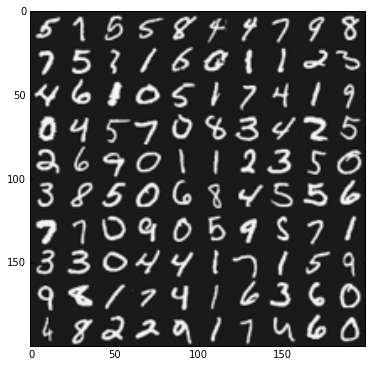

In [4]:
displayData()

#### 1.2 Model representation

In [5]:
#You have been provided with a set of network parameters (Θ(1),Θ(2)) 
#already trained by us. These are stored in ex4weights.mat
datafile = 'data/ex4weights.mat'
mat = scipy.io.loadmat( datafile )
Theta1, Theta2 = mat['Theta1'], mat['Theta2']
# The matrices Theta1 and Theta2 will now be in your workspace
# Theta1 has size 25 x 401
# Theta2 has size 10 x 26

In [6]:
# These are some global variables I'm suing to ensure the sizes
# of various matrices are correct
#these are NOT including bias nits
input_layer_size = 400
hidden_layer_size = 25
output_layer_size = 10 
n_training_samples = X.shape[0]

In [7]:
#Some utility functions. There are lot of flattening and
#reshaping of theta matrices, the input X matrix, etc...
#Nicely shaped matrices make the linear algebra easier when developing,
#but the minimization routine (fmin_cg) requires that all inputs

def flattenParams(thetas_list):
    """
    Hand this function a list of theta matrices, and it will flatten it
    into one long (n,1) shaped numpy array
    """
    flattened_list = [ mytheta.flatten() for mytheta in thetas_list ]
    combined = list(itertools.chain.from_iterable(flattened_list))
    assert len(combined) == (input_layer_size+1)*hidden_layer_size + \
                            (hidden_layer_size+1)*output_layer_size
    return np.array(combined).reshape((len(combined),1))

def reshapeParams(flattened_array):
    theta1 = flattened_array[:(input_layer_size+1)*hidden_layer_size] \
            .reshape((hidden_layer_size,input_layer_size+1))
    theta2 = flattened_array[(input_layer_size+1)*hidden_layer_size:] \
            .reshape((output_layer_size,hidden_layer_size+1))
    
    return [ theta1, theta2 ]

def flattenX(myX):
    return np.array(myX.flatten()).reshape((n_training_samples*(input_layer_size+1),1))

def reshapeX(flattenedX):
    return np.array(flattenedX).reshape((n_training_samples,input_layer_size+1))

#### 1.3 Feedforward and cost function

In [8]:
def computeCost(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    """
    This function takes in:
        1) a flattened vector of theta parameters (each theta would go from one
           NN layer to the next), the thetas include the bias unit.
        2) the flattened training set matrix X, which contains the bias unit first column
        3) the label vector y, which has one column
    It loops over training points (recommended by the professor, as the linear
    algebra version is "quite complicated") and:
        1) constructs a new "y" vector, with 10 rows and 1 column, 
            with one non-zero entry corresponding to that iteration
        2) computes the cost given that y- vector and that training point
        3) accumulates all of the costs
        4) computes a regularization term (after the loop over training points)
    """
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)
    
    #This is what will accumulate the total cost
    total_cost = 0.
    
    m = n_training_samples

    # Loop over the training points (rows in myX, already contain bias unit)
    for irow in xrange(m):
        myrow = myX[irow]
                
        # First compute the hypothesis (this is a (10,1) vector
        # of the hypothesis for each possible y-value)
        # propagateForward returns (zs, activations) for each layer
        # so propagateforward[-1][1] means "activation for -1st (last) layer"
        myhs = propagateForward(myrow,mythetas)[-1][1]

        # Construct a 10x1 "y" vector with all zeros and only one "1" entry
        # note here if the hand-written digit is "0", then that corresponds
        # to a y- vector with 1 in the 10th spot (different from what the
        # homework suggests)
        tmpy  = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        
        # Compute the cost for this point and y-vector
        mycost = -tmpy.T.dot(np.log(myhs))-(1-tmpy.T).dot(np.log(1-myhs))
     
        # Accumulate the total cost
        total_cost += mycost
  
    # Normalize the total_cost, cast as float
    total_cost = float(total_cost) / m
    
    # Compute the regularization term
    total_reg = 0.
    for mytheta in mythetas:
        total_reg += np.sum(mytheta*mytheta) #element-wise multiplication
    total_reg *= float(mylambda)/(2*m)
        
    return total_cost + total_reg
       

def propagateForward(row,Thetas):
    """
    Function that given a list of Thetas (NOT flattened), propagates the
    row of features forwards, assuming the features ALREADY
    include the bias unit in the input layer, and the 
    Thetas also include the bias unit

    The output is a vector with element [0] for the hidden layer,
    and element [1] for the output layer
        -- Each element is a tuple of (zs, as)
        -- where "zs" and "as" have shape (# of units in that layer, 1)
    
    ***The 'activations' are the same as "h", but this works for many layers
    (hence a vector of thetas, not just one theta)
    Also, "h" is vectorized to do all rows at once...
    this function takes in one row at a time***
    """
   
    features = row
    zs_as_per_layer = []
    for i in xrange(len(Thetas)):  
        Theta = Thetas[i]
        #Theta is (25,401), features are (401, 1)
        #so "z" comes out to be (25, 1)
        #this is one "z" value for each unit in the hidden layer
        #not counting the bias unit
        z = Theta.dot(features).reshape((Theta.shape[0],1))
        a = expit(z)
        zs_as_per_layer.append( (z, a) )
        if i == len(Thetas)-1:
            return np.array(zs_as_per_layer)
        a = np.insert(a,0,1) #Add the bias unit
        features = a

In [9]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#you should see that the cost is about 0.287629
myThetas = [ Theta1, Theta2 ]

#Note I flatten the thetas vector before handing it to the computeCost routine,
#as per the input format of the computeCost function.
#It does the unrolling/reshaping itself
#I also flatten the X vector, similarly
print computeCost(flattenParams(myThetas),flattenX(X),y)

0.287629165161


#### 1.4 Regularized cost function

In [10]:
#Once you are done, using the loaded set of parameters Theta1 and Theta2,
#and lambda = 1, you should see that the cost is about 0.383770
myThetas = [ Theta1, Theta2 ]
print computeCost(flattenParams(myThetas),flattenX(X),y,mylambda=1.)

0.384487796243


### 2 Backpropagation

#### 2.1 Sigmoid gradient

In [11]:
def sigmoidGradient(z):
    dummy = expit(z)
    return dummy*(1-dummy)

#### 2.2 Random initialization

In [12]:
def genRandThetas():
    epsilon_init = 0.12
    theta1_shape = (hidden_layer_size, input_layer_size+1)
    theta2_shape = (output_layer_size, hidden_layer_size+1)
    rand_thetas = [ np.random.rand( *theta1_shape ) * 2 * epsilon_init - epsilon_init, \
                    np.random.rand( *theta2_shape ) * 2 * epsilon_init - epsilon_init]
    return rand_thetas

#### 2.3 Backpropagation


In [13]:
def backPropagate(mythetas_flattened,myX_flattened,myy,mylambda=0.):
    
    # First unroll the parameters
    mythetas = reshapeParams(mythetas_flattened)
    
    # Now unroll X
    myX = reshapeX(myX_flattened)

    #Note: the Delta matrices should include the bias unit
    #The Delta matrices have the same shape as the theta matrices
    Delta1 = np.zeros((hidden_layer_size,input_layer_size+1))
    Delta2 = np.zeros((output_layer_size,hidden_layer_size+1))

    # Loop over the training points (rows in myX, already contain bias unit)
    m = n_training_samples
    for irow in xrange(m):
        myrow = myX[irow]
        a1 = myrow.reshape((input_layer_size+1,1))
        # propagateForward returns (zs, activations) for each layer excluding the input layer
        temp = propagateForward(myrow,mythetas)
        z2 = temp[0][0]
        a2 = temp[0][1]
        z3 = temp[1][0]
        a3 = temp[1][1]
        tmpy = np.zeros((10,1))
        tmpy[myy[irow]-1] = 1
        delta3 = a3 - tmpy 
        delta2 = mythetas[1].T[1:,:].dot(delta3)*sigmoidGradient(z2) #remove 0th element
        a2 = np.insert(a2,0,1,axis=0)
        Delta1 += delta2.dot(a1.T) #(25,1)x(1,401) = (25,401) (correct)
        Delta2 += delta3.dot(a2.T) #(10,1)x(1,25) = (10,25) (should be 10,26)
        
    D1 = Delta1/float(m)
    D2 = Delta2/float(m)
    
    #Regularization:
    D1[:,1:] = D1[:,1:] + (float(mylambda)/m)*mythetas[0][:,1:]
    D2[:,1:] = D2[:,1:] + (float(mylambda)/m)*mythetas[1][:,1:]
    
    return flattenParams([D1, D2]).flatten()

In [14]:
#Actually compute D matrices for the Thetas provided
flattenedD1D2 = backPropagate(flattenParams(myThetas),flattenX(X),y,mylambda=0.)
D1, D2 = reshapeParams(flattenedD1D2)

#### 2.4 Gradient checking

In [15]:
def checkGradient(mythetas,myDs,myX,myy,mylambda=0.):
    myeps = 0.0001
    flattened = flattenParams(mythetas)
    flattenedDs = flattenParams(myDs)
    myX_flattened = flattenX(myX)
    n_elems = len(flattened) 
    #Pick ten random elements, compute numerical gradient, compare to respective D's
    for i in xrange(10):
        x = int(np.random.rand()*n_elems)
        epsvec = np.zeros((n_elems,1))
        epsvec[x] = myeps
        cost_high = computeCost(flattened + epsvec,myX_flattened,myy,mylambda)
        cost_low  = computeCost(flattened - epsvec,myX_flattened,myy,mylambda)
        mygrad = (cost_high - cost_low) / float(2*myeps)
        print "Element: %d. Numerical Gradient = %f. BackProp Gradient = %f."%(x,mygrad,flattenedDs[x])

In [16]:
checkGradient(myThetas,[D1, D2],X,y)

Element: 7396. Numerical Gradient = 0.000046. BackProp Gradient = 0.000046.
Element: 5523. Numerical Gradient = 0.000060. BackProp Gradient = 0.000060.
Element: 9584. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.
Element: 1020. Numerical Gradient = -0.000173. BackProp Gradient = -0.000173.
Element: 5080. Numerical Gradient = 0.000244. BackProp Gradient = 0.000244.
Element: 8017. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.
Element: 482. Numerical Gradient = 0.000000. BackProp Gradient = 0.000000.
Element: 393. Numerical Gradient = -0.000001. BackProp Gradient = -0.000001.
Element: 3981. Numerical Gradient = 0.000143. BackProp Gradient = 0.000143.
Element: 9346. Numerical Gradient = 0.000042. BackProp Gradient = 0.000042.


#### 2.5 Regularized Neural Networks

In [17]:
#My back propagation already has regularization in it.
#For now, I will assume the regularization part is correct
#(since in this case the regularization code is simple, I'm quite confident)

#### 2.5 Learning parameters using fmincg

In [18]:
#Here I will use scipy.optimize.fmin_cg

def trainNN(mylambda=0.):
    """
    Function that generates random initial theta matrices, optimizes them,
    and returns a list of two re-shaped theta matrices
    """

    randomThetas_unrolled = flattenParams(genRandThetas())
    result = scipy.optimize.fmin_cg(computeCost, x0=randomThetas_unrolled, fprime=backPropagate, \
                               args=(flattenX(X),y,mylambda),maxiter=50,disp=True,full_output=True)
    return reshapeParams(result[0])

In [19]:
#Training the NN takes about ~70-80 seconds on my machine
learned_Thetas = trainNN()

         Current function value: 0.295915
         Iterations: 50
         Function evaluations: 108
         Gradient evaluations: 108


In [20]:
#If your implementation is correct, you should see a reported training accuracy of about 95.3%
#(this may vary by about 1% due to the random initialization).

In [21]:
def predictNN(row,Thetas):
    """
    Function that takes a row of features, propagates them through the
    NN, and returns the predicted integer that was hand written
    """
    classes = range(1,10) + [10]
    output = propagateForward(row,Thetas)
    #-1 means last layer, 1 means "a" instead of "z"
    return classes[np.argmax(output[-1][1])] 

def computeAccuracy(myX,myThetas,myy):
    """
    Function that loops over all of the rows in X (all of the handwritten images)
    and predicts what digit is written given the thetas. Check if it's correct, and
    compute an efficiency.
    """
    n_correct, n_total = 0, myX.shape[0]
    for irow in xrange(n_total):
        if int(predictNN(myX[irow],myThetas)) == int(myy[irow]): 
            n_correct += 1
    print "Training set accuracy: %0.1f%%"%(100*(float(n_correct)/n_total))

In [22]:
computeAccuracy(X,learned_Thetas,y)

Training set accuracy: 96.2%


In [23]:
#Let's see if I set lambda to 10, if I get the same thing
learned_regularized_Thetas = trainNN(mylambda=10.)

         Current function value: 1.073837
         Iterations: 50
         Function evaluations: 143
         Gradient evaluations: 142


In [24]:
computeAccuracy(X,learned_regularized_Thetas,y)

Training set accuracy: 93.1%


### 3 Visualizing the hidden layer

In [25]:
def displayHiddenLayer(myTheta):
    """
    Function that takes slices of the first Theta matrix (that goes from
    the input layer to the hidden layer), removes the bias unit, and reshapes
    it into a 20x20 image, and shows it
    """
    #remove bias unit:
    myTheta = myTheta[:,1:]
    assert myTheta.shape == (25,400)
    
    width, height = 20, 20
    nrows, ncols = 5, 5
        
    big_picture = np.zeros((height*nrows,width*ncols))
    
    irow, icol = 0, 0
    for row in myTheta:
        if icol == ncols:
            irow += 1
            icol  = 0
        #add bias unit back in?
        iimg = getDatumImg(np.insert(row,0,1))
        big_picture[irow*height:irow*height+iimg.shape[0],icol*width:icol*width+iimg.shape[1]] = iimg
        icol += 1
    fig = plt.figure(figsize=(6,6))
    img = scipy.misc.toimage( big_picture )
    plt.imshow(img,cmap = cm.Greys_r)

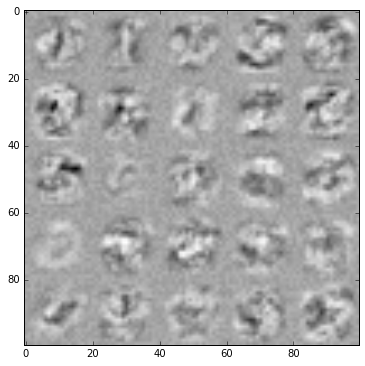

In [26]:
displayHiddenLayer(learned_Thetas[0])